# Trends-based recommendation
In this notebook we will classify the tweets into trends and these trends will help us decide which hashtags to recommend 

In [17]:
import sys

sys.path.append(sys.path[0] + './../')

In [18]:
from NLP.files_reader import *
import tensorflow as tf
import nltk

## Get the data

In [19]:
tweets_and_trends = []
tweets = []
trends = []

files_prefix = './../'

tweets_and_trends += (FilesReader.read_file(files_prefix + new_US_file))
tweets_and_trends += (FilesReader.read_file(files_prefix + new_UK_file))
tweets_and_trends += (FilesReader.read_file(files_prefix + new_AUS_file))
tweets_and_trends += (FilesReader.read_file(files_prefix + new_CAN_file))
tweets_and_trends += (FilesReader.read_file(files_prefix + new_IR_file))

random.shuffle(tweets_and_trends)

tweets, trends = FilesReader.split_tweets_and_trends(tweets_and_trends)
print(f"We have {len(tweets)} tweets.")


We have 132165 tweets.


## Stemming and lemmatization

In [20]:
from NLP.lemmatizer_and_stemmer import LemmatizerAndStemmer

print(f"before: {tweets[:3]}")
for i, tweet in enumerate(tweets):
    processed_tweet = LemmatizerAndStemmer.stem_and_lemmatize_tweet(tweet)
    tweets[i] = processed_tweet
    

print(f"after: {tweets[:3]}")

before: ['tomorrow try spot bee-friendly gardening weekend following great guid', 'guess found wall hangers', 'someone else take corners goodwin wtf man']
after: ['tomorrow tri spot bee-friend garden weekend follow great guid  ', 'guess found wall hanger  ', 'someon el take corner goodwin wtf man  ']


## Tokenize the text

In [21]:
from keras.preprocessing.text import Tokenizer

tweets_tokenizer = Tokenizer(oov_token="<OOV>")
tweets_tokenizer.fit_on_texts(tweets)
tweets_word_index = tweets_tokenizer.word_index
tweets_index_word = tweets_tokenizer.index_word

print(f"We have {len(tweets_word_index)} different words")
print(tweets_word_index)

We have 48706 different words
{'<OOV>': 1, 'day': 2, 'duba': 3, 'like': 4, 'loma': 5, 'get': 6, 'go': 7, 'brown': 8, 'one': 9, 'bobbi': 10, 'im': 11, 'amp': 12, 'man': 13, 'grant': 14, 'game': 15, 'inch': 16, 'shanahan': 17, 'bee': 18, 'better': 19, 'jimmi': 20, 'think': 21, 'dont': 22, 'time': 23, 'heat': 24, 'vincent': 25, 'good': 26, 'victoria': 27, 'gabe': 28, 'play': 29, 'butler': 30, 'celtic': 31, 'team': 32, 'want': 33, 'got': 34, 'show': 35, 'love': 36, 'today': 37, 'make': 38, 'see': 39, 'know': 40, 'shanni': 41, 'may': 42, 'look': 43, 'say': 44, 'would': 45, 'jaylen': 46, 'year': 47, 'u': 48, 'smith': 49, 'haney': 50, 'alvarez': 51, 'marin': 52, 'win': 53, 'back': 54, 'notley': 55, 'need': 56, 'happi': 57, 'weekend': 58, 'late': 59, 'william': 60, 'take': 61, 'player': 62, 'watch': 63, 'last': 64, 'th': 65, 'let': 66, 'said': 67, 'come': 68, 'mahrez': 69, 'he': 70, 'great': 71, 'long': 72, 'kendrick': 73, 'realli': 74, 'way': 75, 'peopl': 76, 'new': 77, 'first': 78, 'cant': 7

## Create the padded sequences

In [22]:
from keras.utils import pad_sequences
sequence_length = 15

tweets_sequences = tweets_tokenizer.texts_to_sequences(tweets)
tweets_sequences_padded = pad_sequences(tweets_sequences, padding="post", maxlen=sequence_length)

## Map the trends to numbers

In [23]:
trends_map = {}

counter = 0

for trend in trends:
    if not (trend in trends_map):
        trends_map[trend] = counter
        counter += 1

no_of_trends = len(trends_map)
inv_trends_map = {v: k for k, v in trends_map.items()}
print(f"We have {no_of_trends} different trends")
print(trends_map)

We have 46 different trends
{'WorldBeeDay': 0, 'TheLastDriveIn': 1, 'CCMvADL': 2, 'FPLCommunity': 3, 'Jaylen Brown': 4, "Starford To'a": 5, 'Dubas': 6, 'Loma': 7, 'Celtics': 8, 'Bobby': 9, 'Jim Brown': 10, 'Grant Williams': 11, 'AFLNorthSwans': 12, 'Victoria Day': 13, 'LE23': 14, 'TaylorCameron': 15, 'Inch': 16, 'SaturdayMorning': 17, 'Shanny': 18, 'Mariners': 19, 'Caturday': 20, 'Mahrez': 21, 'AFLDonsTigers': 22, 'BETTER MAN': 23, 'Stan Grant': 24, 'Notley': 25, 'The Smiths': 26, 'Spezza': 27, 'Alvarez': 28, 'Gabe Vincent': 29, 'Jimmy Butler': 30, 'Kendrick': 31, 'Sheffield Wednesday': 32, 'The Late Late Show': 33, 'Shanahan': 34, 'Andy Rourke': 35, 'Zia Cooke': 36, 'Heat': 37, 'AFLFreoCats': 38, 'Patrick Kielty': 39, 'UKGiftAM': 40, 'LongWeekend': 41, 'ASongOrMovieForStrings': 42, 'NRLDolphinsStorm': 43, 'Kaufusi': 44, 'Tim Sheens': 45}


## Create the trends sequences

In [24]:
trends_sequences = [trends_map[trend] for trend in trends]
print(trends_sequences)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 3, 0, 7, 10, 14, 15, 3, 7, 16, 1, 11, 17, 6, 17, 1, 3, 18, 16, 13, 16, 19, 20, 13, 9, 0, 0, 20, 21, 16, 6, 17, 19, 22, 9, 3, 23, 1, 24, 25, 0, 16, 14, 24, 3, 19, 19, 2, 26, 9, 27, 28, 18, 29, 8, 30, 7, 31, 29, 9, 14, 14, 9, 25, 32, 0, 17, 9, 33, 34, 6, 1, 6, 29, 0, 6, 26, 32, 1, 28, 16, 35, 27, 13, 23, 1, 9, 1, 16, 1, 33, 6, 15, 1, 3, 1, 19, 1, 30, 7, 34, 23, 17, 7, 8, 26, 20, 0, 16, 7, 5, 23, 18, 3, 0, 34, 9, 33, 30, 13, 29, 16, 26, 8, 13, 3, 14, 15, 31, 14, 13, 29, 31, 27, 3, 7, 17, 8, 27, 35, 27, 3, 2, 19, 33, 24, 17, 8, 18, 13, 13, 14, 9, 7, 29, 24, 24, 23, 34, 35, 6, 29, 6, 29, 1, 4, 9, 21, 16, 0, 36, 32, 23, 22, 35, 4, 13, 4, 9, 37, 13, 37, 15, 6, 12, 15, 27, 5, 34, 38, 32, 26, 13, 29, 9, 19, 16, 18, 19, 1, 6, 14, 29, 19, 7, 6, 39, 18, 29, 8, 31, 14, 21, 0, 2, 17, 20, 18, 16, 13, 1, 18, 40, 8, 14, 31, 31, 11, 13, 12, 16, 21, 0, 3, 24, 34, 25, 6, 31, 11, 24, 8, 17, 38, 20, 31, 1, 18, 21, 34, 0, 29, 25, 6, 9, 30, 7, 11, 29, 14, 19, 1, 

## Encode the trends

In [25]:
from keras.utils import to_categorical
import tensorflow as tf

encoded_trends = to_categorical(trends_sequences)
print(encoded_trends.shape)

(132165, 46)


## Prepare the pre-trained embeddings

In [26]:
from NLP.Embeddings.embeddings_matrix import get_embeddings_matrix

embeddings_index_path = "./../NLP/Embeddings/embeddings_index_object.pkl"
embeddings_matrix, hits, misses = get_embeddings_matrix(tweets_word_index, embeddings_index_path)

print(f"Hits: {hits}, Misses: {misses}")

Hits: 27418, Misses: 21288


## Split the data

In [27]:
training_split = 0.8
training_tweets_count = int(0.8 * len(tweets_sequences_padded))

In [28]:
train_data = tweets_sequences_padded[0:training_tweets_count]
train_labels = encoded_trends[0:training_tweets_count]
test_data = tweets_sequences_padded[training_tweets_count:]
test_labels = encoded_trends[training_tweets_count:]

print(f'we have {len(train_data)} tweets for training and {len(test_data)} for testing')

we have 105732 tweets for training and 26433 for testing


## Tune the hyper-parameters

In [29]:
# import keras_tuner as kt
# import keras
# from keras import initializers
# import tensorflow as tf

# no_of_tweets_words = len(tweets_word_index) + 1
# embedding_dimensions = 300

# def model_builder(hp):
#     model = keras.Sequential()

#     hp_conv_filters = hp.Int('conv_filters', min_value=32, max_value=256, step=16)
#     hp_kernel_size = hp.Int('conv_kernel_size', min_value=2, max_value=5, step=1)
#     hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.1)
#     hp_lstm = hp.Int('lstm_units', min_value=32, max_value=256, step=16)

#     model.add(keras.layers.Embedding(
#         no_of_tweets_words,
#         embedding_dimensions,
#         input_length=sequence_length,
#         embeddings_initializer=initializers.Constant(embeddings_matrix),
#         trainable=True
#     ))
#     model.add(keras.layers.Conv1D(hp_conv_filters, hp_kernel_size, padding='same'))
#     model.add(keras.layers.Dropout(hp_dropout))
#     model.add(keras.layers.Bidirectional(keras.layers.LSTM(hp_lstm)))
#     model.add(keras.layers.Dropout(hp_dropout))
#     model.add(keras.layers.Dense(no_of_trends))

#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss=keras.losses.CategoricalCrossentropy(
#                       from_logits=True),
#                   metrics=['accuracy'])

#     return model


In [30]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_accuracy',
#                      max_epochs=6,
#                      factor=3,
#                      directory='parameters_tuning',
#                      project_name='trends_classifier')

In [31]:
# tuner.search(train_data, train_labels, epochs=50, validation_data=(test_data, test_labels))

In [32]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. Here are the optimal configurations:
#     conv_filters: {best_hps.get('conv_filters')}
#     conv_kernel_size: {best_hps.get('conv_kernel_size')}
#     lstm_units: {best_hps.get('lstm_units')}
#     dropout: {best_hps.get('dropout')}
#     learning_rate: {best_hps.get('learning_rate')}
# """)

In [33]:
# trends_classifier = tuner.hypermodel.build(best_hps)
# history = trends_classifier.fit(train_data, train_labels, epochs=20, validation_data=(test_data, test_labels))

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

In [34]:
# trends_classifier = tuner.hypermodel.build(best_hps)
# trends_classifier.fit(train_data, train_labels, epochs=best_epoch, validation_data=(test_data, test_labels))

## Build the model
After tuning the hyper-parameters, here are the optimal configurations: <br>
    conv_filters: 224 <br>
    conv_kernel_size: 2<br>
    lstm_units: 144<br>
    dropout: 0.1<br>
    learning_rate: 0.001<br>

In [35]:
#hyperparameters
embedding_dimensions = 300
lstm_units = 144
dropout_value = 0.1
conv_filters = 224
conv_kernel_size = 2

In [36]:
from keras import initializers
import tensorflow as tf

no_of_tweets_words = len(tweets_word_index) + 1

trends_classifier = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        no_of_tweets_words,
        embedding_dimensions,
        input_length=sequence_length,
        embeddings_initializer=initializers.Constant(embeddings_matrix),
        trainable=True
    ),
    tf.keras.layers.Conv1D(conv_filters, conv_kernel_size, activation='relu'),
    tf.keras.layers.AveragePooling1D(),
    tf.keras.layers.Dropout(dropout_value),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, activation='tanh')),
    tf.keras.layers.Dropout(dropout_value),
    tf.keras.layers.Dense(no_of_trends, activation='softmax')
])

trends_classifier.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

trends_classifier.summary()

# trends_classifier = tf.keras.models.load_model("trends_classifier")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 300)           14612100  
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 224)           134624    
                                                                 
 average_pooling1d_1 (Averag  (None, 7, 224)           0         
 ePooling1D)                                                     
                                                                 
 dropout_2 (Dropout)         (None, 7, 224)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 288)              425088    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 288)              

In [37]:
epochs = 5
history = trends_classifier.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels))

Epoch 1/5
3305/3305 [==============================] - 67s 19ms/step - loss: 0.9397 - accuracy: 0.7534 - val_loss: 0.7418 - val_accuracy: 0.8008
Epoch 2/5
3305/3305 [==============================] - 63s 19ms/step - loss: 0.5782 - accuracy: 0.8402 - val_loss: 0.7077 - val_accuracy: 0.8122
Epoch 3/5
3305/3305 [==============================] - 63s 19ms/step - loss: 0.4072 - accuracy: 0.8831 - val_loss: 0.7580 - val_accuracy: 0.8138
Epoch 4/5
3305/3305 [==============================] - 63s 19ms/step - loss: 0.2923 - accuracy: 0.9143 - val_loss: 0.8121 - val_accuracy: 0.8147
Epoch 5/5
3305/3305 [==============================] - 63s 19ms/step - loss: 0.2189 - accuracy: 0.9344 - val_loss: 0.8934 - val_accuracy: 0.8135


## Save the model

In [38]:
import pickle

trends_classifier.save("../NLP/trends_classifier/trends_classifier_model.h5")
with open('../NLP/trends_classifier/inv_trends_map.pkl', 'wb') as output:
    pickle.dump(inv_trends_map, output)
with open('../NLP/trends_classifier/tweet_tokenizer.pkl', 'wb') as output:
    pickle.dump(tweets_tokenizer, output)


## Confusion matrix

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [40]:
predictions = trends_classifier.predict(test_data)
predicted_trends = np.argmax(predictions, axis=1)
true_trends = np.argmax(test_labels, axis=1)

confusion_matrix = confusion_matrix(true_trends, predicted_trends)

827/827 [==============================] - 3s 3ms/step


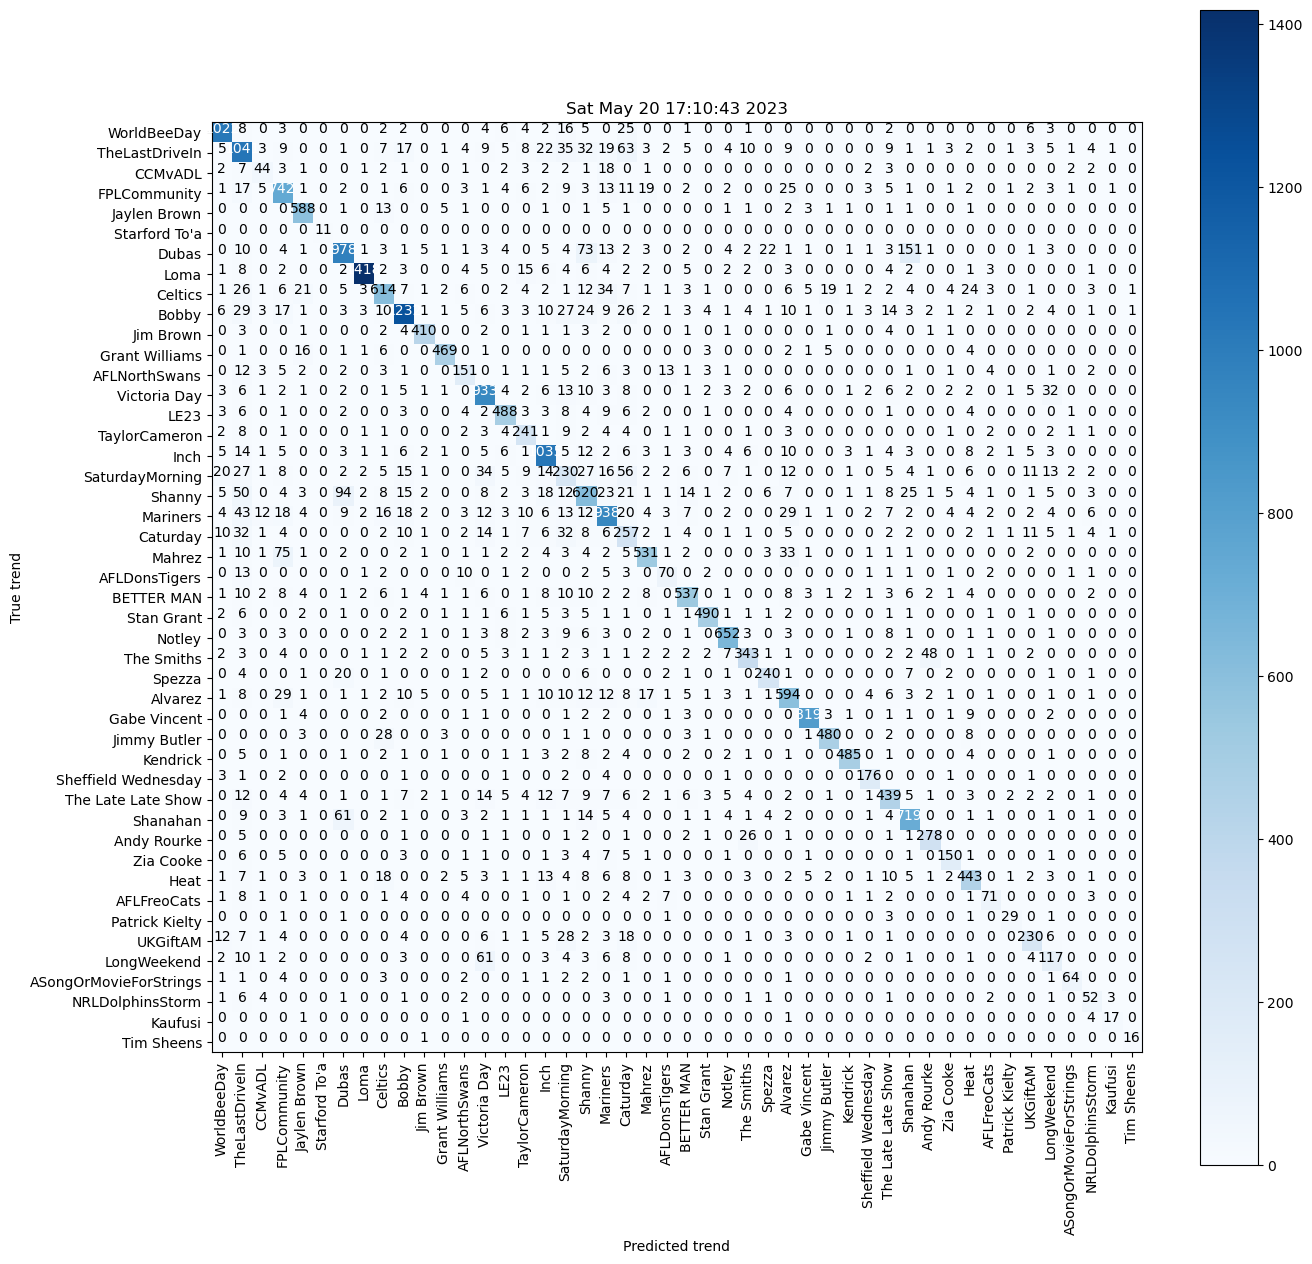

In [41]:
import matplotlib.pyplot as plt
from time import ctime
from sklearn.metrics import classification_report

trends_names = [trend[0] for trend in trends_map.items()]

fig, ax = plt.subplots(figsize=(15, 15))

# Plotting the confusion matrix
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title(ctime())
plt.colorbar(im, ax=ax)

tick_marks = np.arange(len(trends_names))
plt.xticks(tick_marks, trends_names, rotation=90)
plt.yticks(tick_marks, trends_names)

thresh = confusion_matrix.max() / 2.0
for i, j in np.ndindex(confusion_matrix.shape):
    ax.text(j, i, format(confusion_matrix[i, j], 'd'),
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > thresh else "black")

plt.ylabel('True trend')
plt.xlabel('Predicted trend')

plt.savefig('../NLP/Model_reports/plots/' + ctime().replace(' ', '_').replace(':', '_') + '.png', dpi=300)



In [42]:
from sklearn.metrics import classification_report
report = classification_report(true_trends, predicted_trends, target_names=trends_names,  output_dict=True)
print(report)

{'WorldBeeDay': {'precision': 0.9141323792486583, 'recall': 0.9190647482014388, 'f1-score': 0.9165919282511211, 'support': 1112}, 'TheLastDriveIn': {'precision': 0.7024291497975709, 'recall': 0.7739776951672862, 'f1-score': 0.7364697559250087, 'support': 1345}, 'CCMvADL': {'precision': 0.5116279069767442, 'recall': 0.44, 'f1-score': 0.4731182795698925, 'support': 100}, 'FPLCommunity': {'precision': 0.7571428571428571, 'recall': 0.829050279329609, 'f1-score': 0.7914666666666667, 'support': 895}, 'Jaylen Brown': {'precision': 0.8828828828828829, 'recall': 0.9363057324840764, 'f1-score': 0.9088098918083463, 'support': 628}, "Starford To'a": {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 11}, 'Dubas': {'precision': 0.8163606010016694, 'recall': 0.7494252873563219, 'f1-score': 0.7814622453056334, 'support': 1305}, 'Loma': {'precision': 0.9847222222222223, 'recall': 0.9409422694094227, 'f1-score': 0.9623345775364779, 'support': 1507}, 'Celtics': {'precision': 0.797402597402597

In [43]:
print(report['weighted avg'])

{'precision': 0.8176134154859732, 'recall': 0.8135285438656226, 'f1-score': 0.8145181706724866, 'support': 26433}


## Model report

In [44]:
import pandas as pd

report_data_frame_dict = {
    'time': [ctime()],
    'accuracy' : [report['accuracy']],
    'precision' : [report['weighted avg']['precision']],
    'recall' : [report['weighted avg']['recall']],
    'f1_score' : [report['weighted avg']['f1-score']],
    'loss' : [history.history['loss'][-1]],
    'number of tweets': [len(tweets)],
    'number of trends': [no_of_trends]
}

report_data_frame = pd.DataFrame(report_data_frame_dict)

report_data_frame.to_csv('../NLP/Model_reports/model_report.csv', mode='a', index=False, header=False)
